In [2]:
import boto3
import json
import datetime
import pandas as pd
from io import BytesIO
import matplotlib.pyplot as plt

CANSERVER_PARSED_BUCKET = 'matt3r-canserver-us-west-2'
CANSERVER_EVENT_BUCKET = 'matt3r-canserver-event-us-west-2'
IMU_BUCKET = 'matt3r-imu-us-west-2'
s3_client = boto3.client('s3')

In [3]:
start_date_str = '2023-05-03'
end_date_str = '2023-05-05'
organization_id = 'hamid'
k3y_id = '9ed5b50e'
start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.datetime.strptime(end_date_str, '%Y-%m-%d')

In [5]:
# retrieve the event data

# get a list of all json files in the prefix and filter them to within the date range
response = s3_client.list_objects(Bucket=CANSERVER_EVENT_BUCKET, Prefix=organization_id + '/' + 'k3y-' + k3y_id + '/')
all_keys = [item['Key'] for item in response['Contents']]
keys = [file for file in all_keys if datetime.datetime.strptime(file.split('/')[-1].split('.')[0], '%Y-%m-%d') >= start_date
        and datetime.datetime.strptime(file.split('/')[-1].split('.')[0], '%Y-%m-%d') <= end_date]
keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

# retrieve and combine filtered json files
event_dict = {}
for key in keys:
    response = s3_client.get_object(Bucket=CANSERVER_EVENT_BUCKET, Key=key)
    result = json.loads(response["Body"].read().decode())
    for index in result['imu_telematics']:
        if index in event_dict:
            event_dict[index].extend(result['imu_telematics'][index])
        else:
            event_dict[index] = result['imu_telematics'][index]


In [6]:
# retrieve the CAN server data

# get a list of all parquet files in the prefix and filter them to within the date range
response = s3_client.list_objects(Bucket=CANSERVER_PARSED_BUCKET, Prefix=organization_id + '/' + 'k3y-' + k3y_id + '/')
all_keys = [item['Key'] for item in response['Contents']]
keys = [file for file in all_keys if file.split('.')[-1] == 'parquet'
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[0], '%Y-%m-%d') >= start_date
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[0], '%Y-%m-%d') <= end_date]
keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

# retrieve and combine filtered perquet files
df_list = []
for key in keys:
    response = s3_client.get_object(Bucket=CANSERVER_PARSED_BUCKET, Key=key)
    buffer = BytesIO(response['Body'].read())
    can_df = pd.read_parquet(buffer, engine='pyarrow')
    df_list.append(can_df)
can_df = pd.concat(df_list, axis=0, ignore_index=True)

print(can_df.columns)

Index(['timestamp', 'lr_acc', 'bf_acc', 'vert_acc', 'vert_w', 'lr_w', 'bf_w',
       'speed', 'lat', 'long', 'ap_state'],
      dtype='object')


In [7]:
# retrieve the IMU data

# get a list of all parquet files in the prefix and filter them to within the date range
response = s3_client.list_objects(Bucket=IMU_BUCKET, Prefix=organization_id + '/' + 'k3y-' + k3y_id + '/accel/')
all_keys = [item['Key'] for item in response['Contents']]
keys = [file for file in all_keys if file.split('.')[-1] == 'parquet'
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[0], '%Y-%m-%d') >= start_date
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[0], '%Y-%m-%d') <= end_date]
keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

# retrieve and combine filtered perquet files
df_list = []
for key in keys:
    response = s3_client.get_object(Bucket=IMU_BUCKET, Key=key)
    buffer = BytesIO(response['Body'].read())
    imu_df = pd.read_parquet(buffer, engine='pyarrow')
    df_list.append(imu_df)
imu_df = pd.concat(df_list, axis=0, ignore_index=True)

print(imu_df.columns)

Index(['timestamp(epoch in sec)', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)',
       'vert_acc(m/s^2)'],
      dtype='object')


In [ ]:
# plotting the CAN server stationary state accelerations

for state_num in range(len(event_dict['stationary_state'])):
    ss_start_time = event_dict['stationary_state'][state_num]['start']
    ss_end_time = event_dict['stationary_state'][state_num]['end']
    ss_motion = can_df[(can_df['timestamp'] >= ss_start_time) & (can_df['timestamp'] <= ss_end_time)]

    if(len(ss_motion != 0)):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

        fig.set_size_inches(10,6)
        ax1.scatter(x=ss_motion['timestamp'] - ss_start_time, y=ss_motion['lr_acc'], s=1)
        ax1.set_ylim(-15,15)
        ax2.scatter(x=ss_motion['timestamp'] - ss_start_time, y=ss_motion['bf_acc'], s=1)
        ax2.set_ylim(-15,15)
        ax3.scatter(x=ss_motion['timestamp'] - ss_start_time, y=ss_motion['vert_acc'], s=1)
        ax3.set_ylim(-15,15)

        fig.suptitle("CAN Server Acceleraion Metrics (m/s^2) for Stationary State Data")
        fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

        ax1.set_ylabel("Left/Right Acceleration")
        ax2.set_ylabel("Back/Front Acceleration")
        ax3.set_ylabel("Vertical Acceleration")

        plt.tight_layout()
        plt.show()

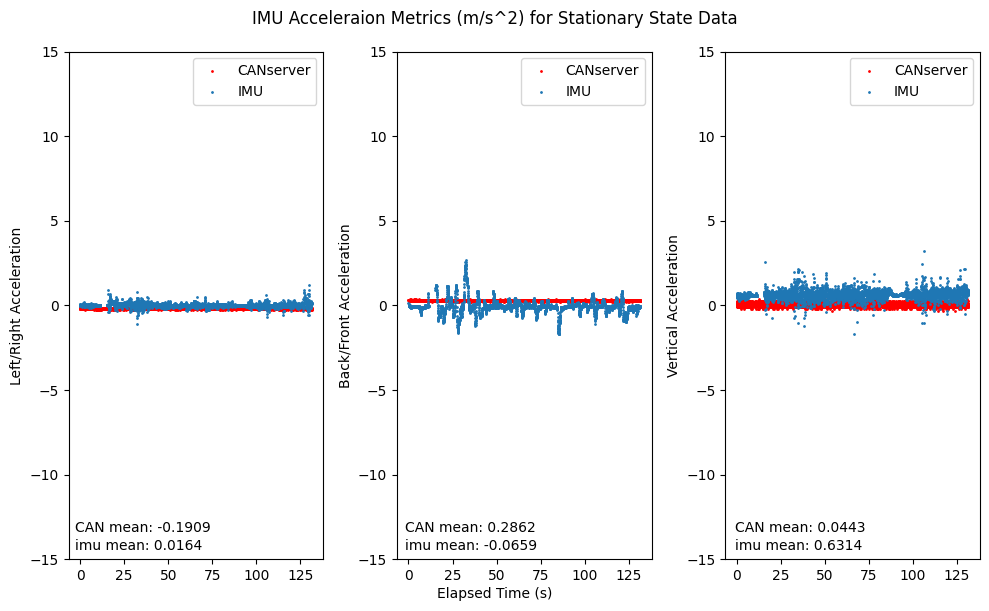

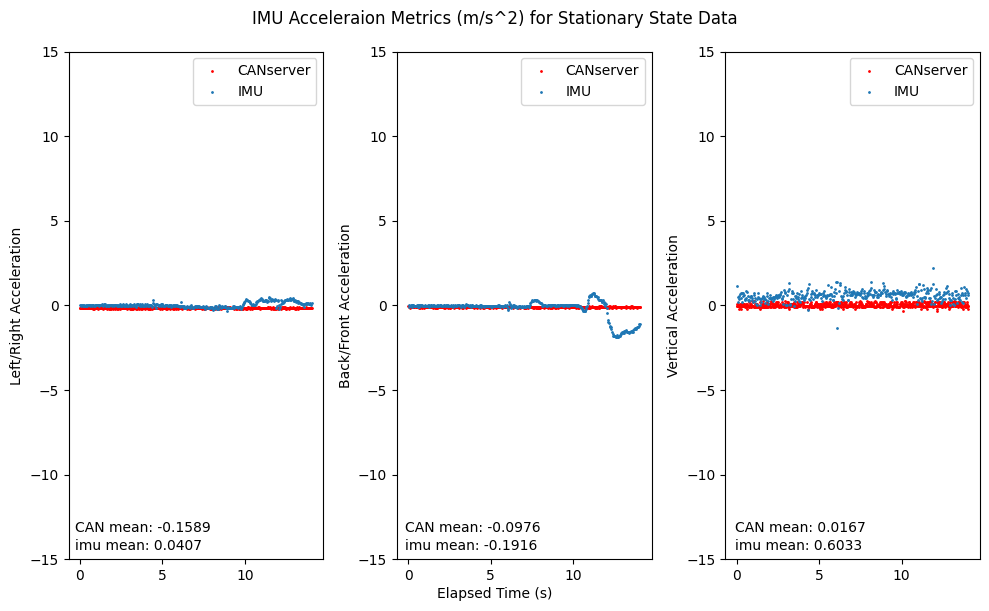

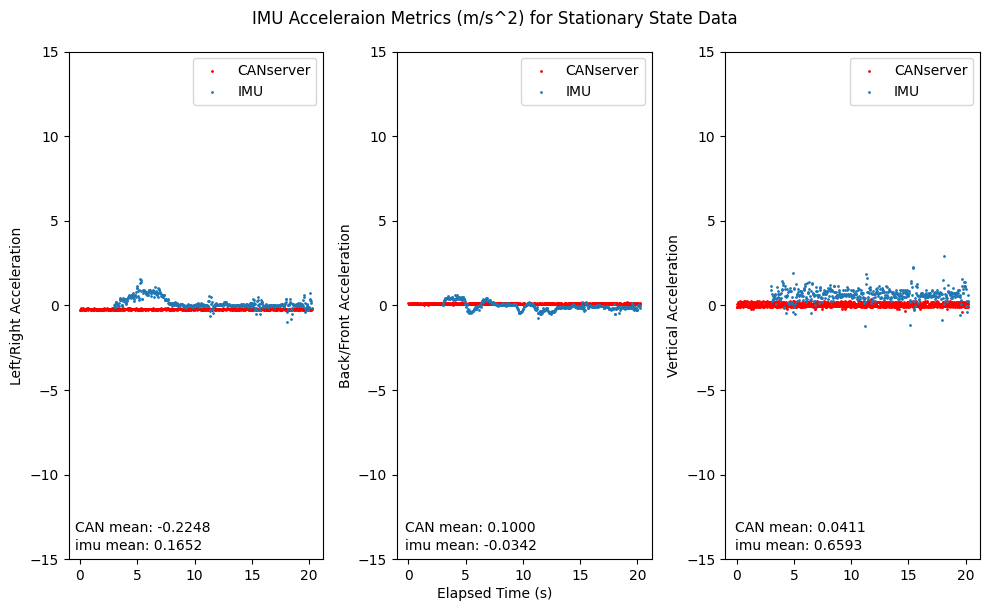

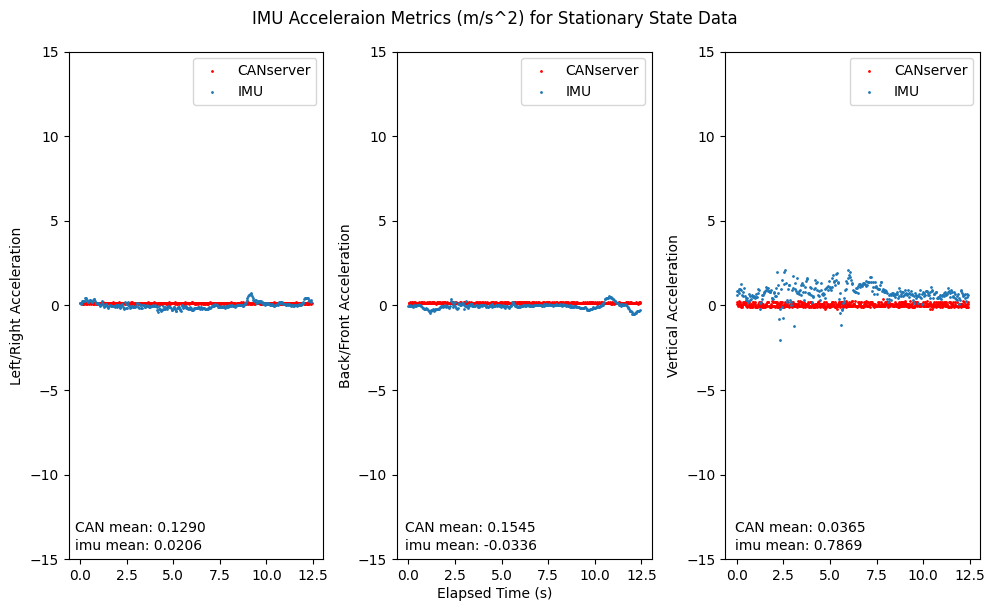

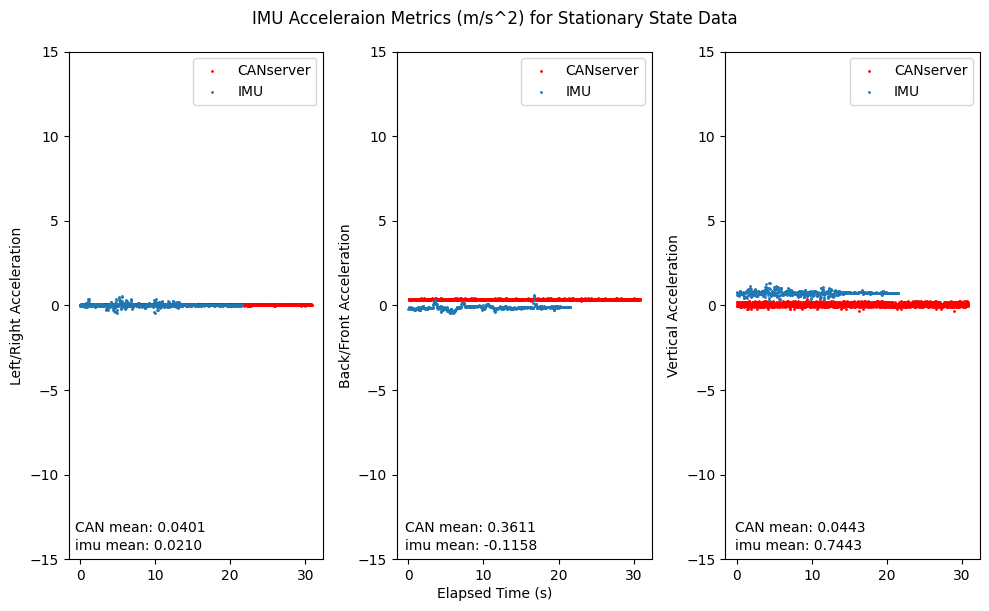

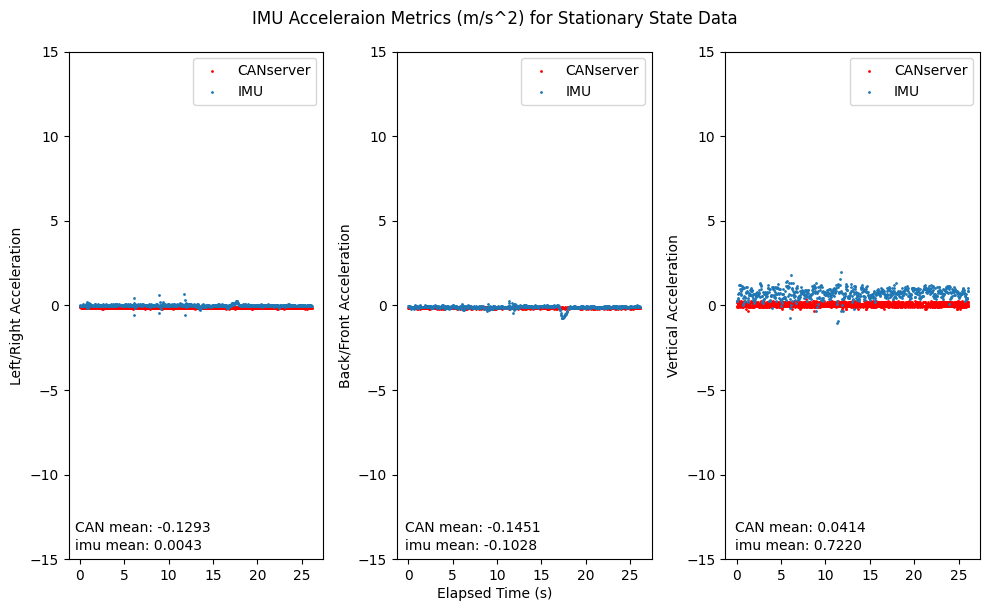

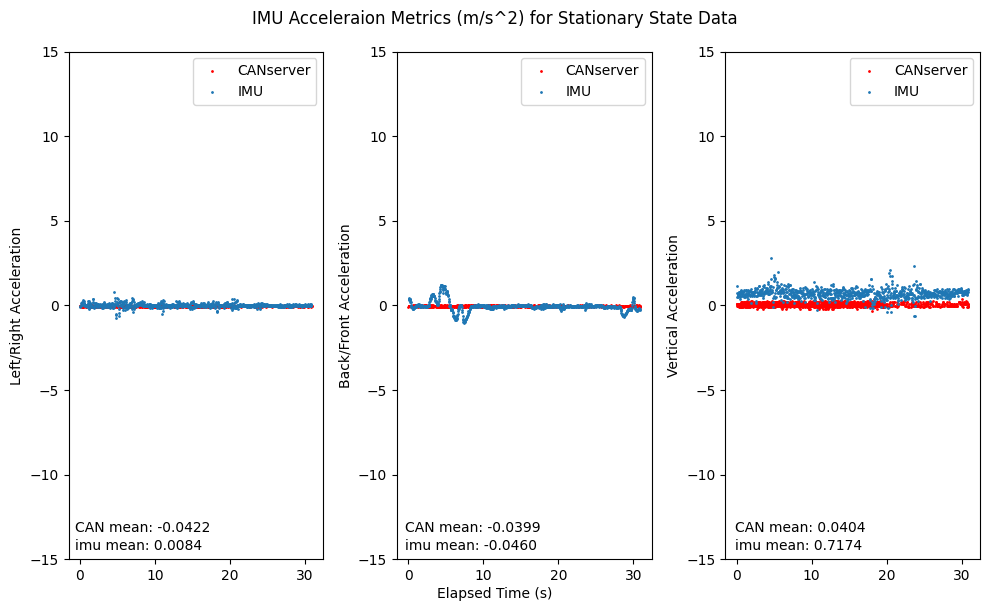

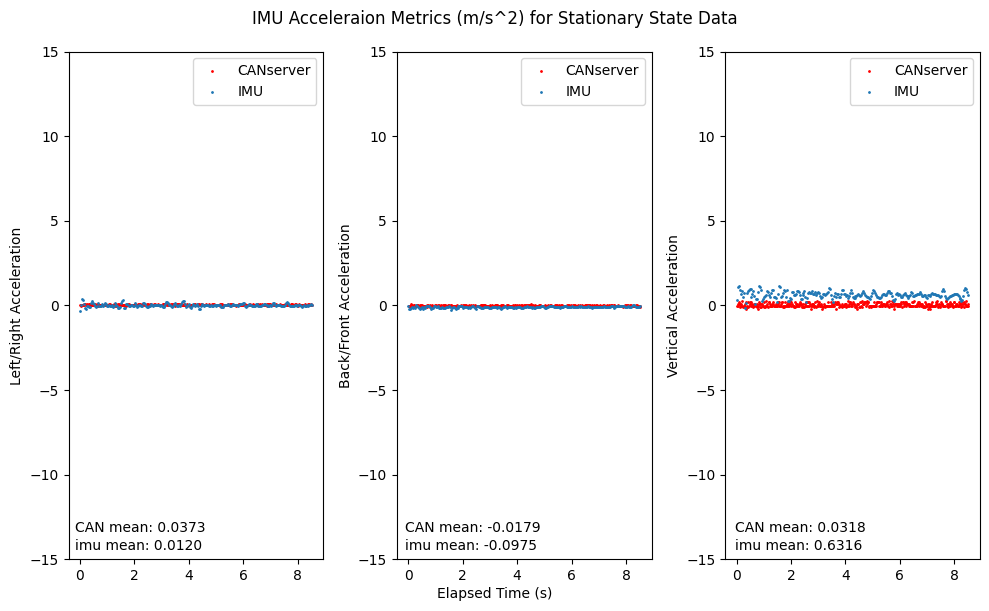

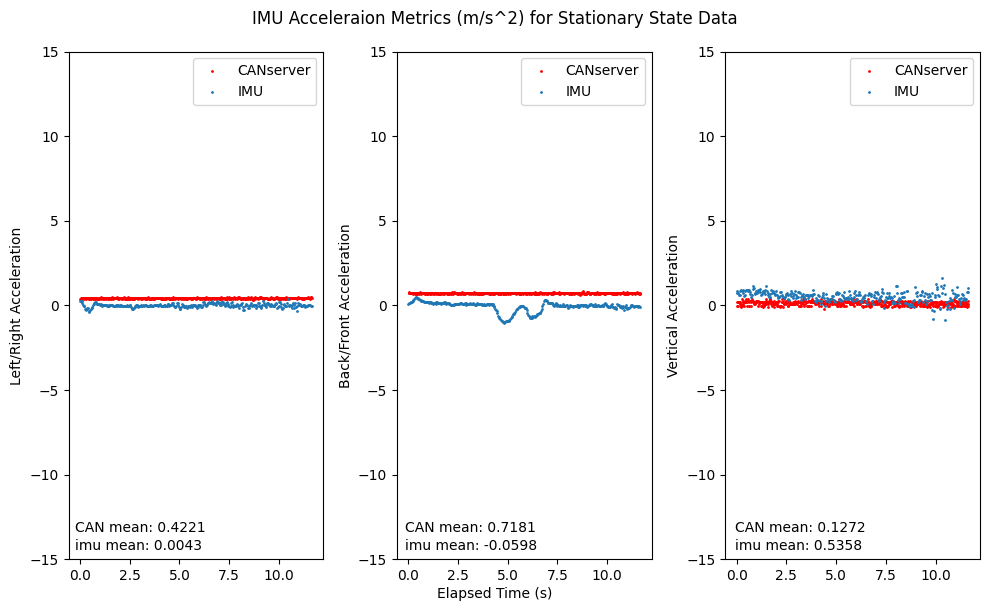

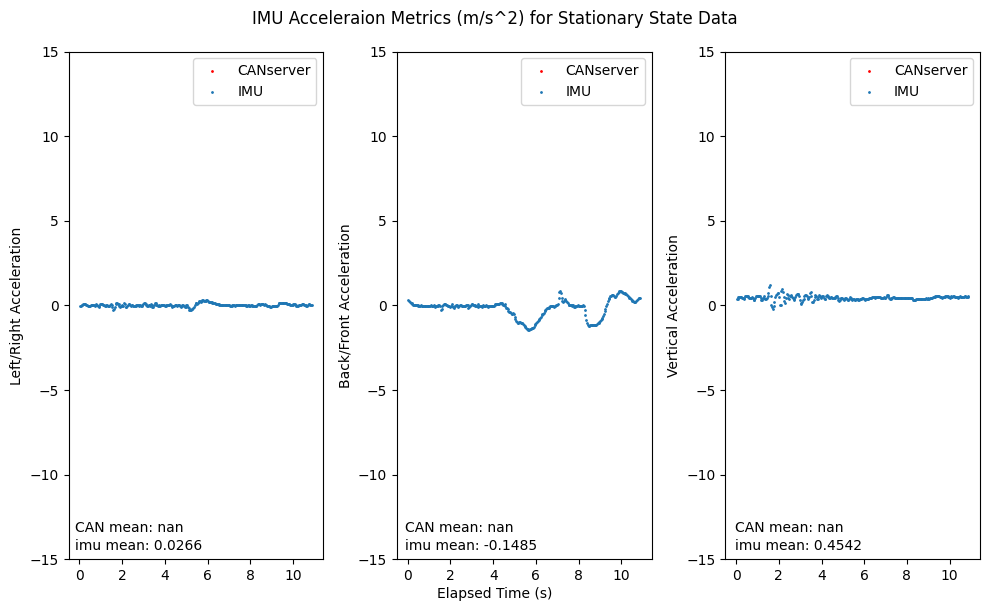

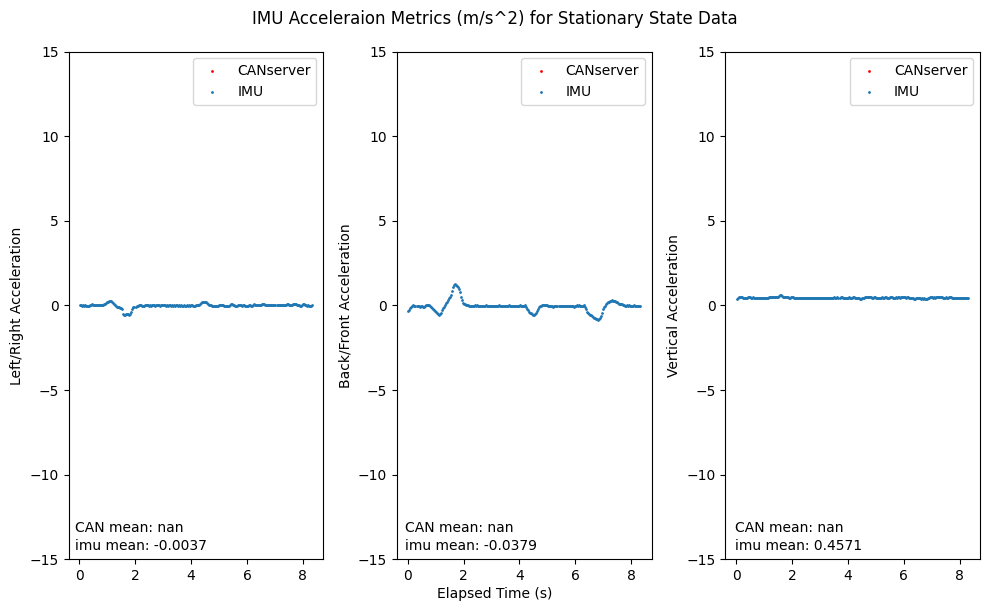

In [32]:
# plotting the IMU stationary state accelerations

for state_num in range(len(event_dict['stationary_state'])):
    ss_start_time = event_dict['stationary_state'][state_num]['start']
    ss_end_time = event_dict['stationary_state'][state_num]['end']
    ss_motion = imu_df[(imu_df['timestamp(epoch in sec)'] >= ss_start_time) & (imu_df['timestamp(epoch in sec)'] <= ss_end_time)]
    can_motion = can_df[(can_df['timestamp'] >= ss_start_time) & (can_df['timestamp'] <= ss_end_time)]

    if (len(ss_motion) != 0):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

        fig.set_size_inches(10,6)

        lr_mean = ss_motion['lr_acc(m/s^2)'].mean()
        bf_mean = ss_motion['bf_acc(m/s^2)'].mean()
        vert_mean = ss_motion['vert_acc(m/s^2)'].mean()
        lr_can_mean = can_motion['lr_acc'].mean()
        bf_can_mean = can_motion['bf_acc'].mean()
        vert_can_mean = can_motion['vert_acc'].mean()

        ax1.scatter(x=can_motion['timestamp'] - ss_start_time, y=can_motion['lr_acc'], s=1, color='red', label='CANserver')
        ax1.scatter(x=ss_motion['timestamp(epoch in sec)'] - ss_start_time, y=ss_motion['lr_acc(m/s^2)'], s=1, label='IMU')
        ax1.set_ylim(-15,15)

        ax2.scatter(x=can_motion['timestamp'] - ss_start_time, y=can_motion['bf_acc'], s=1, color='red', label='CANserver')
        ax2.scatter(x=ss_motion['timestamp(epoch in sec)'] - ss_start_time, y=ss_motion['bf_acc(m/s^2)'], s=1, label='IMU')
        ax2.set_ylim(-15,15)

        ax3.scatter(x=can_motion['timestamp'] - ss_start_time, y=can_motion['vert_acc'], s=1, color='red', label='CANserver')
        ax3.scatter(x=ss_motion['timestamp(epoch in sec)'] - ss_start_time, y=ss_motion['vert_acc(m/s^2)'], s=1, label='IMU')
        ax3.set_ylim(-15,15)

        fig.suptitle("IMU Acceleraion Metrics (m/s^2) for Stationary State Data")
        fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

        fig.text(0.08,0.08,f'imu mean: {lr_mean:.4f}')
        fig.text(0.41,0.08,f'imu mean: {bf_mean:.4f}')
        fig.text(0.74,0.08,f'imu mean: {vert_mean:.4f}')
        fig.text(0.08,0.11,f'CAN mean: {lr_can_mean:.4f}')
        fig.text(0.41,0.11,f'CAN mean: {bf_can_mean:.4f}')
        fig.text(0.74,0.11,f'CAN mean: {vert_can_mean:.4f}')

        ax1.set_ylabel("Left/Right Acceleration")
        ax2.set_ylabel("Back/Front Acceleration")
        ax3.set_ylabel("Vertical Acceleration")

        ax1.legend()
        ax2.legend()
        ax3.legend()
        plt.tight_layout()
        plt.show()

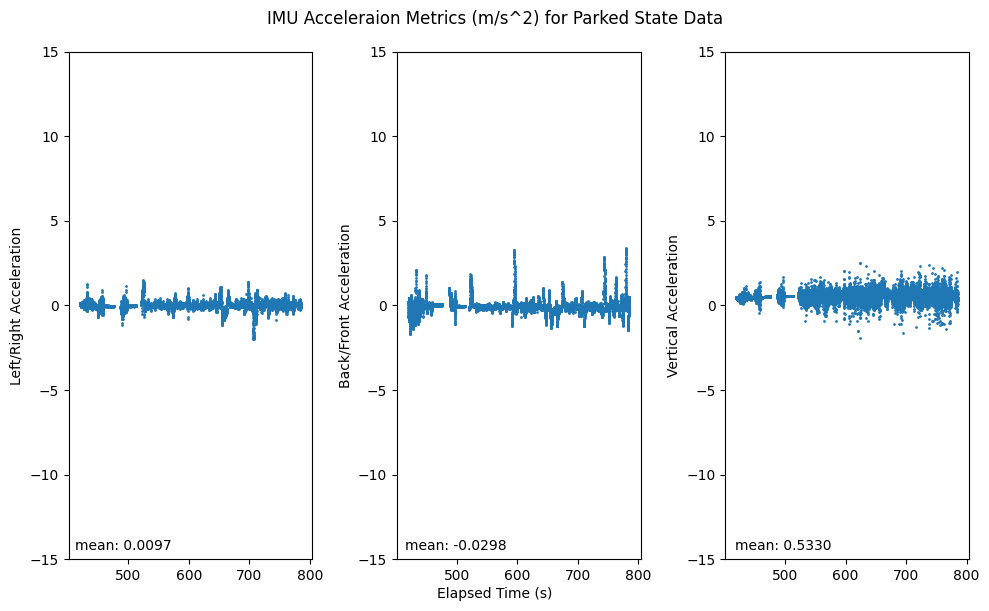

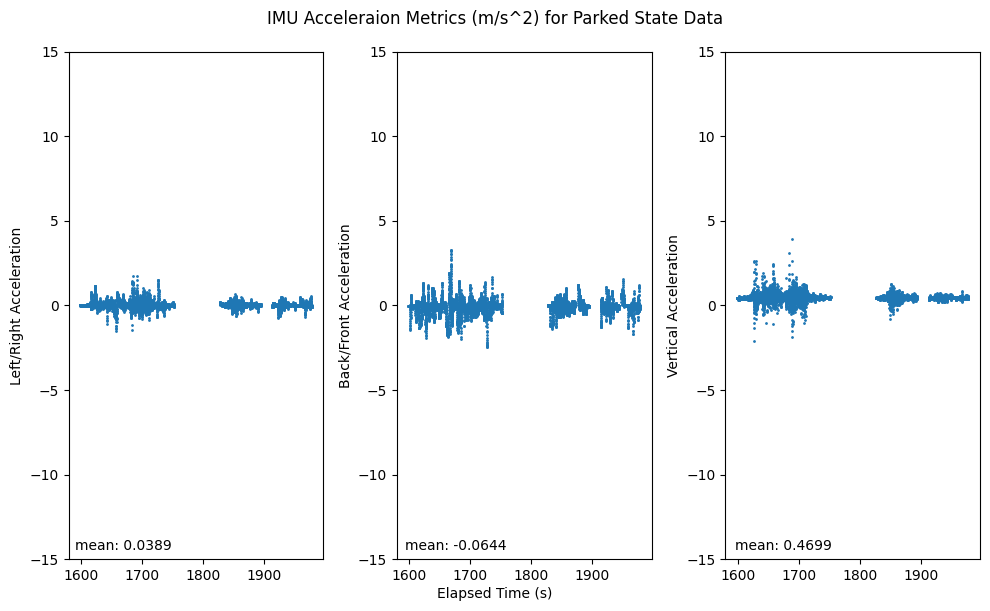

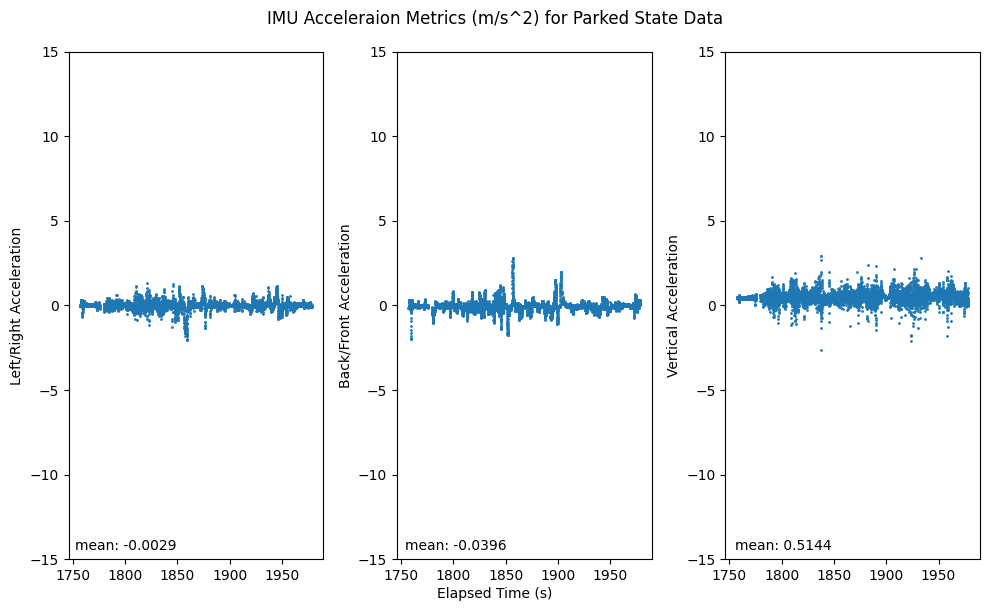

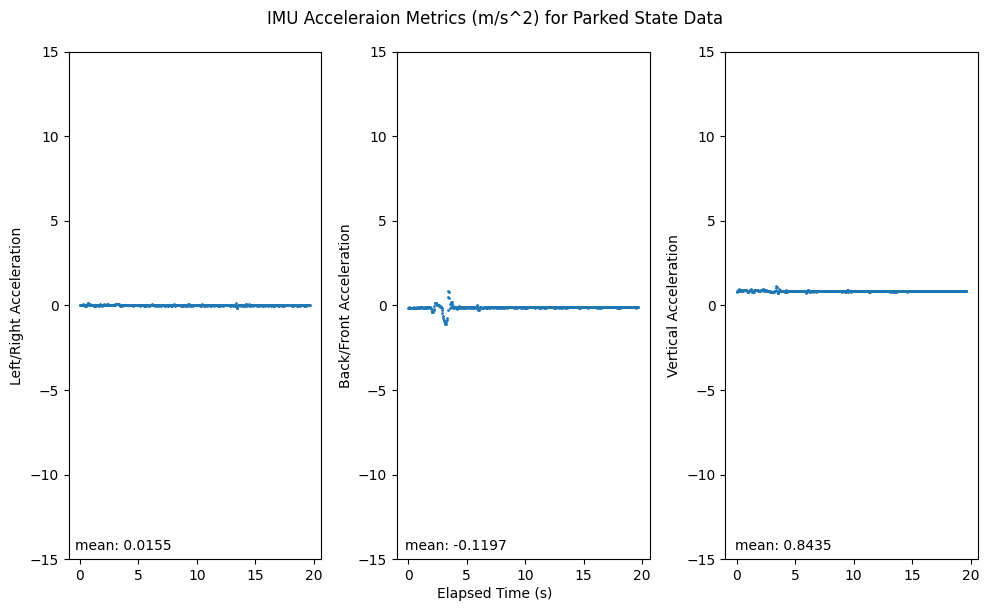

In [26]:
# plotting the IMU parked state accelerations

for state_num in range(len(event_dict['parked_state'])):
    pk_start_time = event_dict['parked_state'][state_num]['timestamp'][0]
    pk_end_time = event_dict['parked_state'][state_num]['timestamp'][1]
    pk_motion = imu_df[(imu_df['timestamp(epoch in sec)'] >= pk_start_time) & (imu_df['timestamp(epoch in sec)'] <= pk_end_time)]
    can_motion = can_df[(can_df['timestamp'] >= pk_start_time) & (can_df['timestamp'] <= pk_end_time)]

    if (len(pk_motion) != 0):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

        fig.set_size_inches(10,6)

        lr_mean = pk_motion['lr_acc(m/s^2)'].mean()
        bf_mean = pk_motion['bf_acc(m/s^2)'].mean()
        vert_mean = pk_motion['vert_acc(m/s^2)'].mean()

        ax1.scatter(x=pk_motion['timestamp(epoch in sec)'] - pk_start_time, y=pk_motion['lr_acc(m/s^2)'], s=1, label='IMU')
        ax1.set_ylim(-15,15)

        ax2.scatter(x=pk_motion['timestamp(epoch in sec)'] - pk_start_time, y=pk_motion['bf_acc(m/s^2)'], s=1, label='IMU')
        ax2.set_ylim(-15,15)

        ax3.scatter(x=pk_motion['timestamp(epoch in sec)'] - pk_start_time, y=pk_motion['vert_acc(m/s^2)'], s=1, label='IMU')
        ax3.set_ylim(-15,15)

        fig.text(0.08,0.08,f'mean: {lr_mean:.4f}')
        fig.text(0.41,0.08,f'mean: {bf_mean:.4f}')
        fig.text(0.74,0.08,f'mean: {vert_mean:.4f}')

        fig.suptitle("IMU Acceleraion Metrics (m/s^2) for Parked State Data")
        fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

        ax1.set_ylabel("Left/Right Acceleration")
        ax2.set_ylabel("Back/Front Acceleration")
        ax3.set_ylabel("Vertical Acceleration")

        plt.tight_layout()
        plt.show()

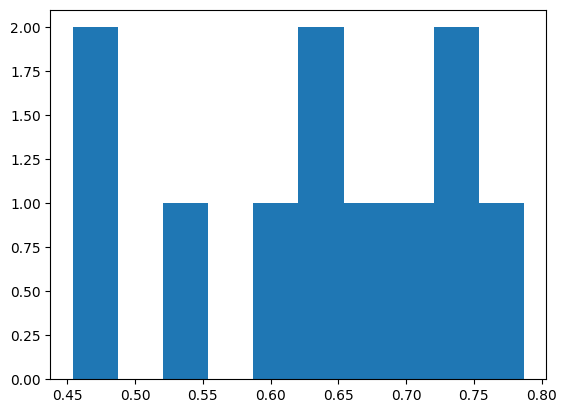

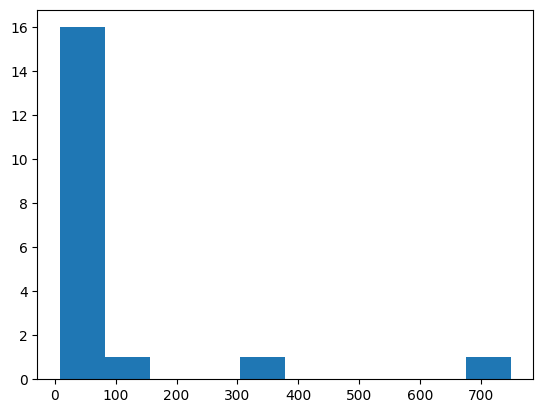

In [49]:
# visualize using a historgam if desired

IMU = True
if(IMU):
    dataframe = imu_df
    timestamp = 'timestamp(epoch in sec)'
else:
    dataframe = can_df
    timestamp = 'timestamp'

mean_bf_acc = []
ss_time = []

for state in event_dict['stationary_state']:
    ss_start_time = state['start']
    ss_end_time = state['end']
    ss_motion = dataframe[(dataframe[timestamp] >= ss_start_time) & (dataframe[timestamp] <= ss_end_time)]

    mean_bf_acc.append(ss_motion['vert_acc(m/s^2)'].mean())
    ss_time.append(ss_end_time - ss_start_time)

plt.hist(mean_bf_acc)
plt.show()
plt.hist(ss_time)
plt.show()